Selected 5 images with 38 rows of annotations
Conversion done. Failed conversions: 0
PNG images saved: 5
Preprocessed 5 images.


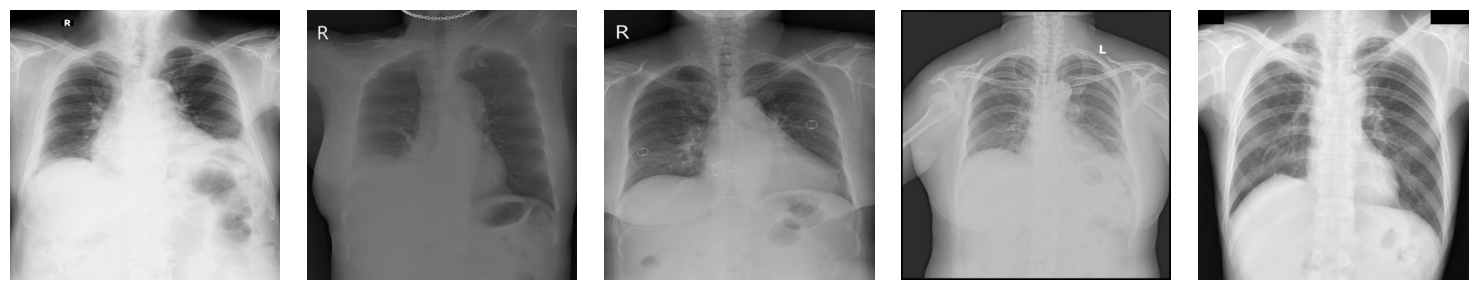

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import pydicom
from PIL import Image

from torchvision import transforms
import torch

warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress formatting warnings

# Step 1: Load CSV and clean data
BASE_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"
train_csv_path = os.path.join(BASE_DIR, "train.csv")

train_df = pd.read_csv(train_csv_path)

# Drop rows with any NaN in bounding box coords or class_name
clean_df = train_df.dropna(subset=['x_min','y_min','x_max','y_max','class_name']).reset_index(drop=True)

# Step 2: Select 5 images with valid data
all_image_ids = clean_df['image_id'].unique()
np.random.seed(42)

if len(all_image_ids) >= 5:
    image_ids_5 = np.random.choice(all_image_ids, 5, replace=False)
else:
    image_ids_5 = all_image_ids

subset_df = clean_df[clean_df['image_id'].isin(image_ids_5)].reset_index(drop=True)

print(f"Selected 5 images with {len(subset_df)} rows of annotations")

# Step 3: Convert DICOM to PNG

dicom_dir = os.path.join(BASE_DIR, "train")
png_out_dir = "/kaggle/working/vinbig_5_png"
os.makedirs(png_out_dir, exist_ok=True)

def dicom_to_uint8(path):
    ds = pydicom.dcmread(path)
    arr = ds.pixel_array.astype(np.float32)
    arr -= arr.min()
    if arr.max() > 0:
        arr /= arr.max()
    arr = (arr * 255).astype(np.uint8)
    if getattr(ds, "PhotometricInterpretation", "") == "MONOCHROME1":
        arr = 255 - arr
    return arr

failed = 0

for img_id in image_ids_5:
    dicom_path = os.path.join(dicom_dir, f"{img_id}.dicom")
    if not os.path.exists(dicom_path):
        dicom_path = os.path.join(dicom_dir, f"{img_id}.dcm")
        if not os.path.exists(dicom_path):
            failed += 1
            continue
    try:
        img_arr = dicom_to_uint8(dicom_path)
        img = Image.fromarray(img_arr)
        img.save(os.path.join(png_out_dir, f"{img_id}.png"))
    except Exception as e:
        failed += 1

print(f"Conversion done. Failed conversions: {failed}")
print(f"PNG images saved: {len(os.listdir(png_out_dir))}")

PNG_DIR = png_out_dir

# Step 4: Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Step 5: Preprocess and load images
preprocessed_tensors = []
processed_ids = []

for img_id in image_ids_5:
    img_path = os.path.join(PNG_DIR, f"{img_id}.png")
    if not os.path.exists(img_path):
        continue
    img = Image.open(img_path).convert("L")
    try:
        t = transform(img)
        preprocessed_tensors.append(t)
        processed_ids.append(img_id)
    except Exception as e:
        print(f"Error processing {img_id}: {e}")

print(f"Preprocessed {len(preprocessed_tensors)} images.")

# Step 6: Visualize the preprocessed images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, t in zip(axes.flatten(), preprocessed_tensors):
    img_np = t[0].cpu().numpy()
    img_np = img_np * 0.5 + 0.5  # unnormalize
    ax.imshow(img_np, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()
